In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import folium

import json
from pathlib import Path
import pymap3d
from datetime import datetime

import pandas as pd

In [2]:
import os
os.environ["PYTHONPATH"]

'D:/projects/PTETA'

In [6]:
# [p for p in Path('../data/routes/chernivtsi/eway/allroutes/bus_38.json').iterdir()]

In [3]:
# f_path = Path('../data/routes/chernivtsi/eway/trolbus/trolbus_11.json')
route_path = Path('../data/routes/chernivtsi/eway/allroutes/bus_38.json')


with open(str(route_path), 'r') as f:
    route_data = json.load(f)

route_data.keys()

dict_keys(['general', 'stops', 'scheme', 'begin', 'end', 'intervals'])

In [4]:
m = folium.Map(
    location=np.mean([[p['x'], p['y']]for p in route_data['stops']['forward']], axis=0), 
    zoom_start=12, height='90%', width='55%'
    )

for coord in route_data['stops']['forward']:
    folium.Circle(
        location=[ coord['x'], coord['y'] ], fill_color='#43d9de', 
        radius=16, popup=f"{coord['i']}) {coord['n']}"
    ).add_to( m )
    
folium.PolyLine(
    locations=[[float(l) for l in p.split(',')] 
               for p in route_data['scheme']['forward'].split(' ')], 
    color='#43d9de'
    ).add_to( m )
    
# for coord in route_data['stops']['backward']:
#     folium.Circle(location=[ coord['x'], coord['y'] ], 
#                   fill_color='green', 
#                   radius=8,
#                  popup=f"{coord['i']}) {coord['n']}"
#                  ).add_to( m )
# folium.PolyLine(
#     locations=[[float(l) for l in p.split(',')] 
#                for p in route_data['scheme']['backward'].split(' ')], 
#     color='green'
#     ).add_to( m )

m

In [5]:
import requests

from PTETA.configs.key_configs import EWAY_CHERNIVTSI_REQUEST_PARAMS as REQ_PARAMS


response = requests.get(
    'https://www.eway.in.ua/ajax/en/chernivtsi/routeInfo/23', 
    cookies=REQ_PARAMS['cookies'], 
    headers=REQ_PARAMS['headers'])
response.json()['general']['tn']


'Bus'

In [161]:
requests.get?

Signature: requests.get(url, params=None, **kwargs)
Docstring:
Sends a GET request.

:param url: URL for the new :class:`Request` object.
:param params: (optional) Dictionary, list of tuples or bytes to send
    in the query string for the :class:`Request`.
:param \*\*kwargs: Optional arguments that ``request`` takes.
:return: :class:`Response <Response>` object
:rtype: requests.Response
File:      c:\users\вадим\appdata\roaming\python\python38\site-packages\requests\api.py
Type:      function


In [8]:
res_general = response.json()['general']
# res_general

In [9]:
# response.json()
ROUTES_DIR = Path('../data/routes/chernivtsi/eway/allroutes')

# [p for p in Path('../data/routes/chernivtsi/eway').iterdir()]
ROUTES_DIR.mkdir(parents=True, exist_ok=True)

In [159]:
for i in range(150): 
    try : 
        response = requests.get(f'https://www.eway.in.ua/ajax/en/chernivtsi/routeInfo/{i}', cookies=cookies, headers=headers)
        res_general = response.json()['general']
        file_name = f"{res_general['tn'].lower()}_{res_general['rn'].upper()}.json"
        print(f"{i:03}) {file_name}")
        
        file_path = ROUTES_DIR/file_name
        
        with open(str(file_path), "w") as out_file:
            json.dump(response.json(), out_file)
            
    except: 
        print(f"{i:03}) Got an error")
        

000) Got an error
001) trolleybus_1.json
002) trolleybus_2.json
003) trolleybus_4.json
004) trolleybus_3.json
005) Got an error
006) trolleybus_6A.json
007) trolleybus_6.json
008) trolleybus_5.json
009) bus_3.json
010) bus_4.json
011) bus_6.json
012) bus_11.json
013) bus_12.json
014) bus_26.json
015) bus_29.json
016) bus_30.json
017) Got an error
018) bus_31.json
019) bus_2.json
020) bus_5.json
021) bus_8.json
022) bus_9A.json
023) bus_10A.json
024) Got an error
025) bus_13.json
026) bus_15.json
027) bus_16.json
028) bus_17.json
029) bus_18.json
030) bus_19.json
031) Got an error
032) bus_21.json
033) bus_22.json
034) bus_23.json
035) bus_26A.json
036) bus_27.json
037) Got an error
038) bus_36.json
039) bus_37.json
040) bus_32.json
041) bus_34.json
042) Got an error
043) bus_38.json
044) bus_39.json
045) bus_1.json
046) bus_1A.json
047) Got an error
048) bus_41.json
049) bus_42.json
050) Got an error
051) Got an error
052) bus_43.json
053) bus_33.json
054) Got an error
055) bus_7.json


In [9]:
forward_route = [[float(l) for l in p.split(',')] 
                 for p in route_data['scheme']['forward'].split(' ')]
forward_route_np = np.array(forward_route)

CHERNIVTSI_CENTER = np.array([48.3, 25.933333])
CHERNIVTSI_CENTER, forward_route_np.shape

(array([48.3     , 25.933333]), (554, 2))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
%load_ext autoreload
%autoreload 2

from PTETA.utils.TrackENU import TrackENU        
        
track_11f = TrackENU(forward_route_np, CHERNIVTSI_CENTER)
len(track_11f), track_11f.track_enu.shape, track_11f.track_geod.shape, forward_route_np.shape

(167, (167, 2), (167, 2), (256, 2))

In [6]:
mx_dist = 50

m = folium.Map(
    location=np.mean([[p['x'], p['y']]for p in route_data['stops']['forward']], axis=0), 
    zoom_start=12, height='90%', width='55%'
    )

opt_route = track_11f.track_geod

print(f"{opt_route.shape} - {track_11f.track_enu.shape}")
    
for coord in opt_route:
    folium.Circle(location=[ coord[0], coord[1] ], 
                  color='blue', 
                  radius=4,
                 ).add_to( m )
    folium.Circle(location=[ coord[0], coord[1] ], 
                  color='green', 
                  radius=mx_dist,
                 ).add_to( m )
    
for coord in forward_route_np:
    folium.Circle(location=[ coord[0], coord[1] ], 
                  color='red', 
                  radius=1,
                 ).add_to( m )
# folium.PolyLine(
#     locations=r.convert_to_geod(opt_route), 
# #     locations=opt_route,
#     color='red'
# #     ).add_to( m )

folium.PolyLine(
    locations=track_11f.track_geod, axis=0,
    color='green'
    ).add_to( m )

# {'proj_vec': array([39.40816411, 11.59206913]), 
#  'proj_length': 41.07772467940181, 
#  'tang_vec': array([  541.09231224, -1839.48649707]), 
#  'distance_to_line': 1917.417915656256, 
#  'proj_point': array([-413.97598403, 1888.60396833])}

for seg_n, _ in enumerate(track_11f.unit_vec):
    res = track_11f.get_proj_on_seg_data(seg_n, CHERNIVTSI_CENTER - 5e-4)
    if res is not None:
#         print(f"{seg_n:03}) {res}")
        folium.PolyLine(
            locations=track_11f.convert_to_geod(np.vstack([res['proj_point'], CHERNIVTSI_CENTER])), 
            color='orange'
        ).add_to(m)

m

(167, 2) - (167, 2)


In [15]:
track_11f.get_proj_on_track(CHERNIVTSI_CENTER)

{'segment_projection': None,
 'optimal_point_dist': {'point_number': 0,
  'dist_to_point': 859.6923694795338,
  'progress': 0.0},
 'track_bounds_dist': {'start': 859.6923694795338, 'end': 5581.278795079648}}

In [10]:
vlc_data_path = Path("../data/local/tables/data_for_17_OCT_2022.csv")
df = pd.read_csv(vlc_data_path)
[p for p in Path("../data/local/tables/").iterdir()][-10:]

[WindowsPath('../data/local/tables/data_for_21_SEP_2022.csv'),
 WindowsPath('../data/local/tables/data_for_22_SEP_2022.csv'),
 WindowsPath('../data/local/tables/data_for_23_SEP_2022.csv'),
 WindowsPath('../data/local/tables/data_for_24_SEP_2022.csv'),
 WindowsPath('../data/local/tables/data_for_25_SEP_2022.csv'),
 WindowsPath('../data/local/tables/data_for_26_SEP_2022.csv'),
 WindowsPath('../data/local/tables/data_for_27_SEP_2022.csv'),
 WindowsPath('../data/local/tables/data_for_28_SEP_2022.csv'),
 WindowsPath('../data/local/tables/data_for_29_SEP_2022.csv'),
 WindowsPath('../data/local/tables/data_for_30_SEP_2022.csv')]

In [11]:
df

,id,imei,name,stateCode,stateName,lat,lng,speed,orientation,gpstime,routeId,routeName,routeColour,inDepo,busNumber,perevId,perevName,remark,online,idBusTypes
0,295,355227046283032,A208,used,used,48.266298,25.989323,0.0,0.00,2022-10-16 20:25:10,11,9,magenta,True,0937,13.0,Олег Валентинович 39 марш,0937 DNSNK,True,1.0
1,327,355227046453452,H9,used,used,48.324452,25.934493,0.0,331.25,2022-10-16 21:27:30,7,6,sienna,True,6802,1.0,Денисівка,6802 DNSNTNK,True,1.0
2,347,355227046450995,H29,used,used,48.265292,25.990010,0.0,124.24,2022-10-16 20:48:56,37,T,coral,True,365,6.0,ЧТУ,Тролейбус 365 DNSNTNK,True,2.0
3,282,355227046504098,A195,used,used,48.266328,25.927887,0.0,0.00,2022-10-16 20:57:24,42,39,coral,False,0854,13.0,Олег Валентинович 39 марш,0854 DNSNK,True,1.0
4,271,355227046313847,A184,used,used,48.266255,25.991443,0.0,0.00,2022-10-16 21:26:28,37,T,coral,True,387,6.0,ЧТУ,тролейбус 387 DNSNK,True,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260995,243,355227045600988,A158,used,used,48.267342,25.940062,11.9,251.60,2022-10-17 22:58:49,33,8T,coral,False,324,6.0,ЧТУ,Тролейбус 324 DNSNK,True,2.0
260996,243,355227045600988,A158,used,used,48.267307,25.939843,0.0,0.00,2022-10-17 22:59:09,33,8T,coral,False,324,6.0,ЧТУ,Тролейбус 324 DNSNK,True,2.0
260997,243,355227045600988,A158,used,used,48.267328,25.939118,24.3,281.26,2022-10-17 22:59:29,33,8T,coral,False,324,6.0,ЧТУ,Тролейбус 324 DNSNK,True,2.0
260998,243,355227045600988,A158,used,used,48.267478,25.938045,34.1,282.82,2022-10-17 22:59:39,33,8T,coral,False,324,6.0,ЧТУ,Тролейбус 324 DNSNK,True,2.0


In [11]:
# li = []

# for filename in [p for p in Path("../data/local/tables").iterdir()][-10:]:
#     df = pd.read_csv(filename)
#     li.append(df)

# frame = pd.concat(li, axis=0, ignore_index=True)

In [13]:
# df[df['routeName'] == '20'][['id', 'imei', 'name', 'routeName']].value_counts()

In [12]:
# parquet_data_path = Path("../data/local//data_for_17_OCT_2022.parquet")
# # df.to_parquet(vlc_data_path)
# df.to_parquet(parquet_data_path)

In [15]:
df[df['routeName'] == '38'][['id', 'imei', 'name', 'routeName']].value_counts()

id   imei             name  routeName
418  355228043198843  H100  38           1685
415  355228043198686  H97   38           1544
417  355228043199379  H99   38             57
dtype: int64

In [14]:
df['routeName'].unique()

array(['9', '6', 'T', '39', '5', '1', '12', '11', '38', '27', '34', '8T',
       '4', '2', '20', '13', '6/6a', 'A', '10', '19', '3/3a', '23', '25',
       '1A', '9A', '4T', '9T', '5T', '2A', '1T', '2T', '10A'],
      dtype=object)

In [9]:
df[(df['routeName'] == "11")| (df['routeName'] == "11/3") ][['imei', 'routeName']].value_counts()

imei             routeName
355227046453528  11           3928
355227046451027  11           3574
355227045540572  11           2800
355227045541208  11            810
355227046451332  11              1
dtype: int64

In [17]:
# df[df['imei'] == 355228043198843  ]

In [18]:
def rgb_to_hex(r, g, b):
    return f'{r:02x}{g:02x}{b:02x}'


def plot_coloured_route(route, folium_map, color_map=mpl.cm.get_cmap('jet'), bins=10):
    bins = min(bins, len(route))
    
    lspace = np.linspace(0, len(route), num=bins+1, dtype=int)
    
    for i, (lb, rb) in enumerate(zip(lspace[:-1], lspace[1:]) ):
        clr = rgb_to_hex(*tuple(map(lambda x : int(x*255), color_map(i/bins) ))[:3])
        folium.PolyLine(
            route[lb:rb+1, :],
            color=f"#{clr}", weight=2,
            opacity=0.8
        ).add_to(folium_map)

In [ ]:
355227046453528  11           3928
355227046451027  11           3574
355227045540572  11           2800
355227045541208  11            810
355227046451332  11              1

In [19]:
# updata_tm = [datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').timestamp() for dt in sum_df['gpstime'].unique() ]
# updata_tm_np = np.array(updata_tm)

gps_data = df[df['imei'] == 355228043198843][['lat', 'lng', 'gpstime']].values
gps_data[:, 2] = [datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').timestamp() for dt in gps_data[:, 2] ]
gps_data = gps_data.astype(float)
gps_data[:, 2] -= datetime.strptime(vlc_data_path.name[9:-4], '%d_%b_%Y').timestamp()

In [12]:
# plt.plot(np.diff(gps_data[:, 2]))

In [13]:
np.diff(gps_data[:, 2])[np.diff(gps_data[:, 2]) <= 0 ]

array([0., 0., 0., 0.])

In [20]:
trace = gps_data[:, :2]

m = folium.Map(
    location=np.mean(trace, axis=0), 
    zoom_start=12, height='50%', width='55%'
    )

plot_coloured_route(trace, m)

m

In [17]:
import time
from tqdm import tqdm

In [18]:
%load_ext autoreload
%autoreload 2

from PTETA.utils.TrackENU import TrackENU        
        
track_11f = TrackENU(forward_route_np, CHERNIVTSI_CENTER)
len(track_11f), track_11f.track_enu.shape, track_11f.track_geod.shape, forward_route_np.shape

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(167, (167, 2), (167, 2), (256, 2))

In [19]:
# r.convert_to_enu(gps_data[:, :2])
track_11f.convert_to_enu(gps_data [0, :2])

array([[ 4302.63406435, -3748.82497236]])

In [20]:
gps_data [0, :2]

array([48.26627167, 25.99128833])

In [21]:
dists = [None] * len(gps_data)

st = time.perf_counter()

for i, coord in tqdm(enumerate(gps_data[:, :2])):
    dists[i] = track_11f.get_proj_on_track(track_11f.convert_to_enu(coord))

end = time.perf_counter()
print(f"{end - st}")

3635it [00:03, 918.47it/s]

3.9778400999999803


In [29]:
%load_ext autoreload
%autoreload 2


from PTETA.utils.RouteENU import RouteENU
route11 = RouteENU(route_data, CHERNIVTSI_CENTER)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
route11.track_forward.track_geod

In [30]:
# route11.track_forward.track_geod

m = folium.Map(
    location=np.mean(route11.track_forward.track_geod, axis=0), 
    zoom_start=12, height='90%', width='55%'
    )

folium.PolyLine(
    locations=route11.track_forward.track_geod, axis=0,
    color='green'
    ).add_to( m )

folium.PolyLine(
    locations=route11.track_backward.track_geod, axis=0,
    color='red'
    ).add_to( m )

m

In [32]:
route_proj = route11.get_projection_on_track(gps_data[:, :2])

In [33]:
route_proj.backward

array([[2891.9538623 ,    0.        ],
       [2891.9538623 ,    0.        ],
       [2891.9538623 ,    0.        ],
       ...,
       [2891.73609453,    0.        ],
       [2895.43954113,    0.        ],
       [2895.43954113,    0.        ]])

In [35]:
route_proj.backward[0, :]

array([2891.9538623,    0.       ])

In [56]:
gps_data[:, 2]/3600

array([ 4.22527778,  4.30611111,  4.38944444, ..., 21.02277778,
       21.02666667, 21.11027778])

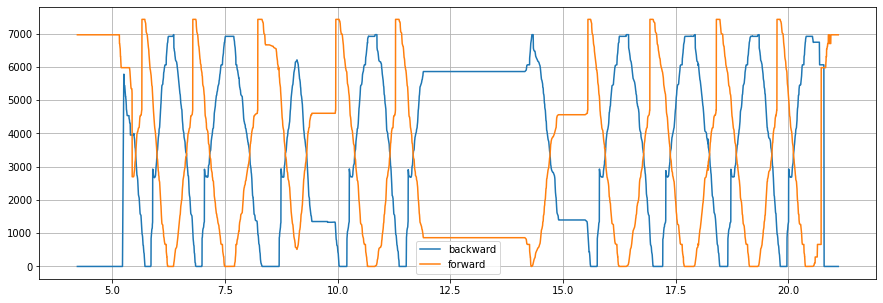

In [59]:
plt.figure(figsize=(15, 5))
# plt.plot(route_proj.backward[:, 0], label='start')
plt.plot(gps_data[:, 2]/3600, route_proj.backward[:, 1], label='backward')
plt.plot(gps_data[:, 2]/3600, route_proj.forward[:, 1], label='forward')
# plt.plot([r['track_bounds_dist']['end'] for r in dists], label='end')
# plt.ylim(-10, 8500)
plt.legend()
plt.grid()

In [76]:
np.minimum(route_proj.backward[:, 0], route_proj.backward[:, 0])

array([2891.9538623 , 2891.9538623 , 2891.9538623 , ..., 2891.73609453,
       2895.43954113, 2895.43954113])

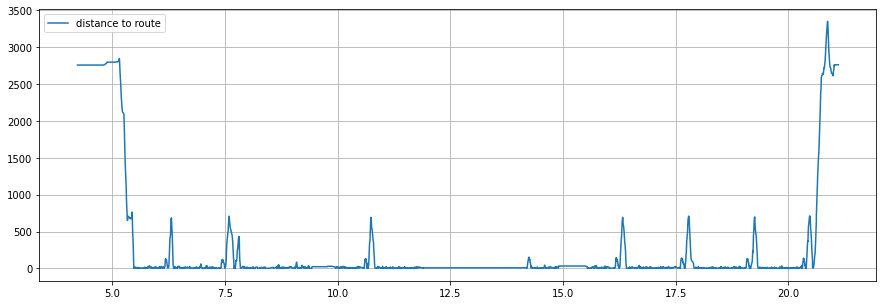

In [78]:
plt.figure(figsize=(15, 5))
# plt.plot(route_proj.backward[:, 0], label='start')

# plt.plot(gps_data[:, 2]/3600, route_proj.backward[:, 0], label='backward')
# plt.plot(gps_data[:, 2]/3600, route_proj.forward[:, 0], label='forward')

dist_to_route = np.minimum( route_proj.forward[:, 0],  route_proj.backward[:, 0])

plt.plot(gps_data[:, 2]/3600, dist_to_route, label='distance to route')

# plt.plot([r['track_bounds_dist']['end'] for r in dists], label='end')
# plt.ylim(-10, 8500)
plt.legend()
plt.grid()

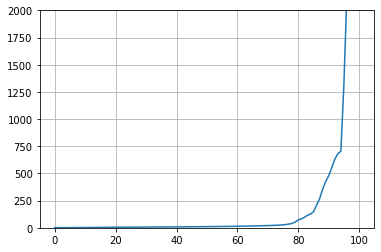

In [95]:

lspace = np.linspace(0, 1., 101)
plt.plot(lspace*100, 
         [np.quantile(dist_to_route, q) for q in lspace]
        )

plt.ylim(-1, 2000)
plt.grid()

In [101]:
np.mean([np.quantile(dist_to_route, q) for q in lspace][:95])
[np.quantile(dist_to_route, q) for q in lspace][90]

478.21347479672636

In [105]:
sum(dist_to_route > 478.2)/ len(dist_to_route)

0.10013755158184319

In [71]:
# route11.track_forward.track_geod

m = folium.Map(
    location=np.mean(route11.track_forward.track_geod, axis=0), 
    zoom_start=12, height='90%', width='55%'
    )

folium.PolyLine(
    locations=gps_data[200:300, :2], axis=0,
    color='red'
    ).add_to( m )

m

In [57]:
# dists[1222]

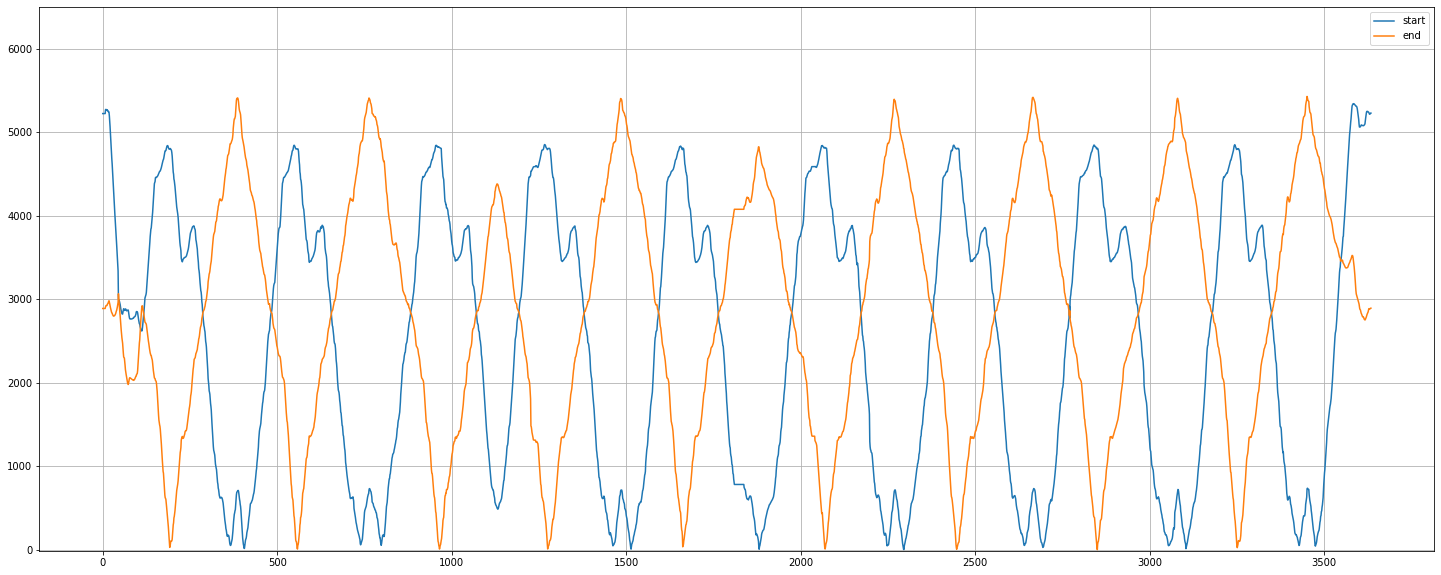

In [54]:
plt.figure(figsize=(25, 10))
plt.plot([r['track_bounds_dist']['start'] for r in dists], label='start')
plt.plot([r['track_bounds_dist']['end'] for r in dists], label='end')
plt.ylim(-10, 6500)
plt.legend()
plt.grid()

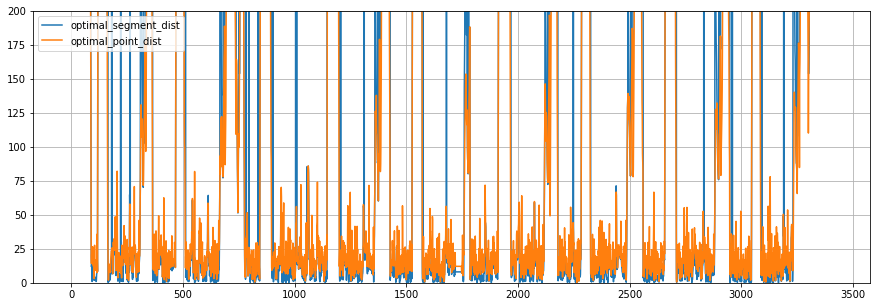

In [55]:
plt.figure(figsize=(15, 5))
lb, rb = 0, -1
plt.plot([r['segment_projection']['distance_to_line'] 
          for r in dists[lb:rb] if r['segment_projection'] is not None], 
        label = "optimal_segment_dist")
plt.plot([r['optimal_point_dist']['dist_to_point'] 
          for r in dists[lb:rb] if r['segment_projection'] is not None], 
        label = "optimal_point_dist")
plt.ylim(0, 200)

plt.grid()
plt.legend()

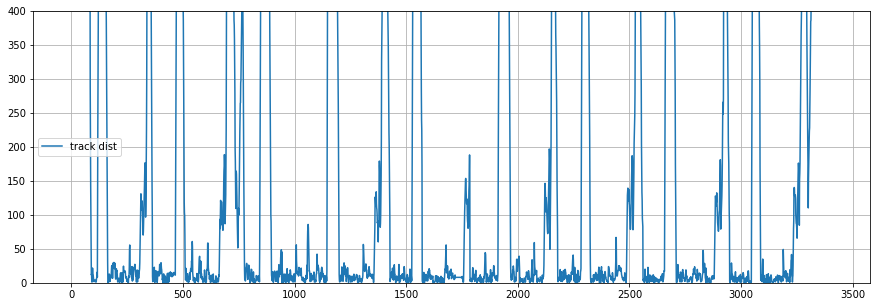

In [56]:
plt.figure(figsize=(15, 5))
lb, rb = 0, -1
plt.plot([min(r['segment_projection']['distance_to_line'], 
              r['optimal_point_dist']['dist_to_point']  )
          for r in dists[lb:rb] if r['segment_projection'] is not None], 
        label = "track dist")
# plt.plot([r['optimal_point_dist']['dist_to_point'] 
#           for r in dists[lb:rb] if r['segment_projection'] is not None], 
#         label = "optimal_point_dist")
plt.ylim(0, 400)

plt.grid()
plt.legend()